In [8]:
from collections import deque
import numpy as np
import matplotlib.pyplot as plt
import random

from bbutils import BetaBernoulli

In [9]:
category2idx = dict()
idx2category = []
categories = []
observations = []

with open('predictions.txt', 'r') as f:
    next(f)
    for line in f:
        _, correct, predicted, confidence = line.split()
        
        if predicted not in category2idx:
            category2idx[predicted] = len(category2idx)
            idx2category.append(predicted)
        idx = category2idx[predicted]
        
        categories.append(idx)
        observations.append(correct == predicted)


In [10]:
# Try to identify worst class

n = 501
k = 100
runs = 10000
# pseudo_count = 2
mode = 'min'

active_choices = np.zeros((runs, k, n))
active_thetas = np.zeros((runs, k, n))
random_thetas = np.zeros((runs, k, n))

for r in range(runs):

    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)

    # Random model
    model = BetaBernoulli(k)

#     # Prior
#     # model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0
    for i in range(n):
        while True:
            category = random.randrange(k)
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        model.update(category, observation)
        random_thetas[r, :, i] = model._params[:,0] / (model._params[:,0] + model._params[:,1])
    
    # Queue choices for each category
    deques = [deque() for _ in range(k)]
    for category, observation in zip(categories, observations):
        deques[category].append(observation)

    # Beta Bernoulli model
    model = BetaBernoulli(k)

    # Prior
    # model._params = np.vstack((alpha, beta)).T

    n_success = 0
    total = 0

    for i in range(n):
        theta_hat = model.sample()
        
        if mode == 'max':
            choices = np.argsort(theta_hat)[::-1]
        elif mode == 'min':
            choices = np.argsort(theta_hat)
            
        for j in range(k):
            category = choices[j]
            if len(deques[category]) != 0:
                break
        observation = deques[category].pop()
        model.update(category, observation)
        #beta_bernoulli_outcome[i] = n_success / (total + 1e-13)
        active_thetas[r, :, i] = model._params[:,0] / (model._params[:,0] + model._params[:,1])
        if i > 0:
            active_choices[r, :, i] = active_choices[r, :, i - 1]
        active_choices[r, category, i] += 1

In [11]:
correct = np.zeros(k)
total = np.zeros(k)

for category, observation in zip(categories, observations):
    if observation:
        correct[category] += 1
    total[category] += 1
    
empirical_acc = correct / total
ranked = np.argsort(empirical_acc)[::-1]

lizard
boy
couch
girl
bear
man
bridge
poppy
squirrel
tulip


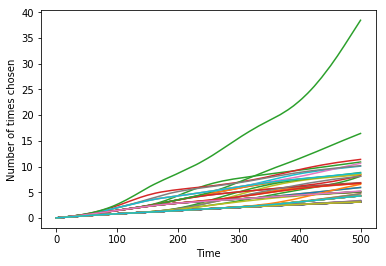

In [12]:
avg_active_choices = np.mean(active_choices, axis=0)

for i in range(k):
    plt.plot(avg_active_choices[i,:])
    plt.xlabel('Time')
    plt.ylabel('Number of times chosen')

top = np.argsort(avg_active_choices[:,-1])[::-1]

for i in top[:10]:
    print(idx2category[i])

In [13]:
most_chosen = np.argmax(active_choices[:, :, :], axis=1)

cutoff = 9

if mode == 'max':
    selection = ranked[:cutoff]
elif mode == 'min':
    selection = ranked[-cutoff:]
    selection = selection[::-1]
    
timestamps = [100, 200, 300, 400, 500]

table = np.zeros((cutoff+1, len(timestamps)))
    
for i, category in enumerate(selection):
    for j, timestamp in enumerate(timestamps):
        table[i,j] = np.mean(most_chosen[:,timestamp] == category)

table[cutoff,:] = 1 - np.sum(table, axis=0)

In [14]:
header = ' ' * 10 + ' '.join('%6i' % x for x in timestamps)
print(header)

for i, row in enumerate(table):
    if i < cutoff:
        category = idx2category[selection[i]]
    else:
        category = 'OTHER'
    category_string = '{:10s}'.format(category)
    num_string = ' '.join('{:.04f}'.format(x) for x in row.tolist())
    print(category_string + num_string)

             100    200    300    400    500
lizard    0.3179 0.9210 0.9973 1.0000 1.0000
seal      0.0001 0.0000 0.0000 0.0000 0.0000
otter     0.0005 0.0000 0.0000 0.0000 0.0000
shrew     0.0000 0.0000 0.0000 0.0000 0.0000
boy       0.0050 0.0029 0.0019 0.0000 0.0000
bear      0.0517 0.0020 0.0000 0.0000 0.0000
woman     0.0074 0.0000 0.0000 0.0000 0.0000
couch     0.3320 0.0162 0.0004 0.0000 0.0000
shark     0.0000 0.0000 0.0000 0.0000 0.0000
OTHER     0.2854 0.0579 0.0004 0.0000 0.0000


In [23]:
random_success = np.mean(np.argmin(random_thetas, axis=1) == selection[0], axis=0)
active_success = np.mean(np.argmin(active_thetas, axis=1) == selection[0], axis=0)

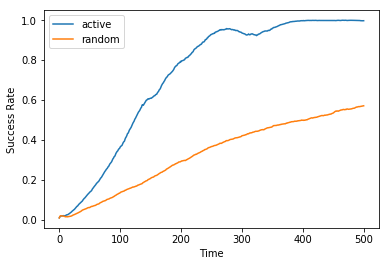

In [26]:
plt.plot(active_success, label='active')
plt.plot(random_success, label='random')
plt.xlabel('Time')
plt.ylabel('Success Rate')
plt.legend()